# Importing libs and setting constants

In [ ]:
from pathlib import Path
import tarfile
import pandas as pd
 
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
! pip install catboost
from catboost import CatBoostClassifier
from catboost import cv, Pool
from catboost import Pool
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif, chi2
from scipy.stats import chisquare

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
pd.options.mode.chained_assignment = None
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

     |████████████████████████████████| 67.3MB 59kB/s 


In [ ]:
SEED = 97

# Extracting data

In [ ]:
gdd.download_file_from_google_drive(file_id='1hIjLXNNbkyWUZ7edL9KhJHcs8NaKw7JK',
                                    dest_path='./hackaton.rar')
get_ipython().system_raw("unrar x hackaton.rar")

# Reading data

In [ ]:
aggregates = pd.read_csv('/content/hackaton/aggregates.csv', parse_dates=['report_date', 'cre_date'], dayfirst=False)
print(aggregates.shape)

(177963, 220)


In [ ]:
transactions = pd.read_csv('/content/hackaton/transactions.csv', parse_dates=['last_day_month'], dayfirst=False)
print(transactions.shape)

(751747, 8)


In [ ]:
features_to_drop = ['report_date', 'cre_date', 'client_id']

# EDA aggregates
## Введем таргет
target: 1 - человек в следующем месяце взял кредит, 0 - иначе

In [ ]:
# Отсутсвие информации об открытых потребительских кредитах свидетельствует об их отсутсвии
aggregates['cl_open'].fillna(0, inplace=True)

In [ ]:
# Последний месяц в данных
max_date = max(aggregates['report_date'])
# Создаем коптю датафрейма aggregates
df1 = aggregates.copy()
# shift_date - слудующий месяц
df1['shift_date'] = df1['report_date'] + pd.tseries.offsets.DateOffset(months=1)

df2 = aggregates[['client_id', 'report_date', 'cl_open']].copy()

In [ ]:
# В качестве таргета берем клиентов, которые в следующем месяце возьмут кредит
df = df1.merge(df2, how='left', left_on=['client_id', 'shift_date'], right_on=['client_id', 'report_date'])
df = df[(df['report_date_x'] != max_date) & (~df['cl_open_y'].isna())]
df['target'] = df['cl_open_y'] > df['cl_open_x']
# Уберем лишнее
df = df.drop(['report_date_y', 'cl_open_y', 'shift_date'], axis=1).rename(columns={'report_date_x': 'report_date', 'cl_open_x': 'cl_open'})

In [ ]:
# Убираем клиентов с подозрительно большим числом открытых кредитов
strange_clients = df[df['cl_open'] > 15]['client_id']
df = df[~df['client_id'].isin(strange_clients)]

In [ ]:
# Убираем лишний возраст
df = df[(df['age'] >= 20) & (df['age'] <= 70)]

In [ ]:
# Наблюдается несбалансированность классов
df['target'].value_counts(normalize=True)

False    0.976331
True     0.023669
Name: target, dtype: float64

## Categorical Features

In [ ]:
# Смотрим типы данных: есть object
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157506 entries, 0 to 177962
Columns: 221 entries, client_id to target
dtypes: bool(1), datetime64[ns](2), float64(211), int64(1), object(6)
memory usage: 265.7+ MB


### Object type

In [ ]:
# Смотрим типы данных object
categorial_df = df.select_dtypes(include=['object'])
categorial_df.head(4)

,app_rel_status,app_education_nm,app_industry_nm,app_employment_type_nm,app_position_type_nm,app_client_category
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,женат / замужем,Высшее,Другое,Основная сфера деят-ти,не руководящий сотрудник,Клиенты розничного кредитования


In [ ]:
# Приведем к нижнему регистру
def lower_case(series):
  def series_app(x):
    if isinstance(x, str):
      x = str.lower(x)
    return x
  series = series.apply(series_app)
  return series

categorial_df = categorial_df.apply(lower_case, axis=1)

In [ ]:
# Объявляем серию мапперов, по одному на каждую из object колонок
def map0(x):
  if isinstance(x, str):
    if ('не замужем' in x) or ('незамужем' in x) or (x=='одинокий'):
      x = 'холост'
    if ('состоит в незарегистрированном браке' in x) or (x=='замужем') or (x=='женат') or (x=='женат / замужем (брачный контракт)')\
      or (x=='женат / замужем') or (x=='состоит в зарегистрированном браке'):
      x = 'женат/замужем'
    if (x=='в разводе') or (x=='разведен(а) официально (развод зарегистрирован)'):
      x = 'разведен/разведена'
    if (x=='вдова/вдовец') or (x=='вдовец (вдова)'):
      x = 'вдовец/вдова'
    if x==' ':
      x=np.nan
  return x

def map1(x):
  if isinstance(x, str):
    if (x=='среднее-специальное') or (x=='среднее специальное'):
      x = 'средне-специальное'
    if (x=='незаконченное высшее'):
      x = 'неполное высшее'
    if x==' ':
      x=np.nan
  return x

def map2(x):
  if isinstance(x, str):
    if (x=='иное'):
      x = 'другое'
    if (x==' ') or (x=='0'):
      x=np.nan
    if (x=='тэк/ химия и нефтехимия') or (x=='химическая пром-ть') or (x=='нефтегазовая отрасль') or (x=='тэк'):
      x='xимическая и нефтехимическая промышленность'
    if (x=='добывающая пром-ть') or (x=='иные виды промышленности и добычи') or (x=='металлургия'):
      x='металлургический комплекс'
    if (x=='энергетика/ транспорт/ связь') or (x=='машиностроение'):
      x = 'машиностроение'
    if (x=='информационные технологии/коммуникации') or (x=='информационные технологии') or (x=='телекоммуникации'):
      x = 'ИТ'
    if (x=='банки и финансы') or (x=='банки/ финансы/ страхование'):
      x = 'банки и финансы'
    if (x=='банки/ финансы/ страхование') or (x=='легкая/пищевая пром-ть') or (x=='легкая промышленность') or (x=='пищевая промышленность'):
      x = 'легкая/пищевая промышленность'
    if (x=='общественное питание'):
      x = 'сфера услуг'
    if (x=='образование') or (x=='наука') or (x=='спортивные организации') or (x=='культура') or (x=='социальная сфера')\
         or (x=='общественные организации') or (x=='сми') or (x=='издательская деят-ть'):
      x = 'наука/ образование/ культура'
    if (x=='торговля розничная') or (x=='торговля оптовая'):
      x = 'торговля'
  return x

def map3(x):
  if isinstance(x, str):
    if (x==' ') or (x=='0'):
      x=np.nan
    if (x=='основная сфера деятельности') or (x=='основная сфера деят-ти'):
      x = 'основная сфера деятельности'
    if (x=='юридическая служба'):
      x = 'юриспруденция'
    if (x=='основная деятельность организации/предпр') or (x=='основная деятельность организации/предприятия'):
      x = 'основная сфера деятельности'
    if (x=='бухгалтерия, финансы'):
      x = 'бухгалтерия, финансы, планирование'
    if (x=='отдел кадров'):
      x = 'кадровая служба, секретариат'
    if (x=='административно-хозяйственная служба'):
      x = 'администрация/трансп.'
    if (x=='строительство') or (x=='машиностроение') or (x=='реклама и маркетинг'):
      x = 'другое'
  return x

def map4(x):
  if isinstance(x, str):
    if (x=='руководитель (зам. рук-ля) подра'):
      x = 'руководитель (зам. рук-ля) подразделения'
    if x==' ':
      x=np.nan
    if (x=='руководитель (зам. рук-ля) орган'):
      x = 'руководитель (зам. рук-ля) организации'
    if (x=='судья'):
      x = 'служащий'
    if (x=='руководитель высшего звена'):
      x = 'руководитель (зам. рук-ля) организации'
    if (x=='не руководящий сотрудник'):
      x = 'специалист'
  return x

def map5(x):
  if isinstance(x, str):
    if (x=='сотрудники группы газпром') or (x=='сотрудники группы гпб, группы газпром и аналогичные условия кредитования')\
         or (x=='сотрудники газпромбанка'):
      x = 'сотрудники группы гпб, группы газпром и сотрудники организаций с аналогичными условиями кредитования'
    if (x=='сторонние физические лица'):
      x = 'прочие физические лица'
  return x

In [ ]:
# Маппим категорию клиента
categorial_df.iloc[:, 5] = categorial_df.iloc[:, 5].apply(map5)
categorial_df.iloc[:, 5].value_counts(dropna=False)

NaN                                                                                                     51213
сотрудники группы гпб, группы газпром и сотрудники организаций с аналогичными условиями кредитования    37244
прочие физические лица                                                                                  31075
сотрудники приоритетных организаций                                                                     16643
клиенты розничного кредитования                                                                         16528
сотрудники организаций - участников розничного кредитования                                              4467
стоп - лист                                                                                               207
сотрудники организаций на зарплатном проекте                                                               85
сотрудники стратегических / спец. клиентов, бюджетных учрежд                                               23
private ba

In [ ]:
# Маппим уровень занимаемой позиции
categorial_df.iloc[:, 4] = categorial_df.iloc[:, 4].apply(map4)
categorial_df.iloc[:, 4].value_counts(dropna=False)

NaN                                         127871
специалист                                   23743
руководитель (зам. рук-ля) подразделения      3197
иное                                           877
руководитель (зам. рук-ля) организации         644
рабочий                                        542
военнослужащий                                 250
руководитель среднего звена                    133
руководитель начального звена                   97
служащий                                        83
высококвалифицированный специа                  69
Name: app_position_type_nm, dtype: int64

In [ ]:
# Маппим тип занимаемой должности
categorial_df.iloc[:, 3] = categorial_df.iloc[:, 3].apply(map3)
categorial_df.iloc[:, 3].value_counts(dropna=False)

NaN                                   129552
основная сфера деятельности            22823
технический персонал                    2653
бухгалтерия, финансы, планирование       876
администрация/трансп.                    499
служба безопасности                      384
кадровая служба, секретариат             258
телекоммуникации                         245
юриспруденция                            201
другое                                    15
Name: app_employment_type_nm, dtype: int64

In [ ]:
# Маппим сферу деятельности
categorial_df.iloc[:, 2] = categorial_df.iloc[:, 2].apply(map2)
categorial_df.iloc[:, 2].value_counts(dropna=False)

NaN                                            78147
другое                                         22905
xимическая и нефтехимическая промышленность    17137
машиностроение                                 10915
металлургический комплекс                      10352
наука/ образование/ культура                    3906
сфера услуг                                     3517
строительство                                   2242
банки и финансы                                 1900
торговля                                        1567
легкая/пищевая промышленность                   1367
здравоохранение                                  817
правоохран. система                              801
сельское хозяйство                               469
транспорт                                        418
муницип. и фед. управ.                           316
армия                                            241
коммунальное хоз-во                              181
туризм                                        

In [ ]:
# Маппим уровень образования
categorial_df.iloc[:, 1] = categorial_df.iloc[:, 1].apply(map1)
categorial_df.iloc[:, 1].value_counts(dropna=False)

NaN                   123700
высшее                 17869
средне-специальное     10519
среднее                 3204
два и более высших      1090
неполное высшее         1006
ученая степень           118
Name: app_education_nm, dtype: int64

In [ ]:
# Маппим семейное положение
categorial_df.iloc[:, 0] = categorial_df.iloc[:, 0].apply(map0)
categorial_df.iloc[:, 0].value_counts(dropna=False)

NaN                              121138
женат/замужем                     23328
холост                             7643
разведен/разведена                 3932
никогда не состоял(а) в браке      1065
вдовец/вдова                        314
гражданский брак                     86
Name: app_rel_status, dtype: int64

In [ ]:
# Переносим полученные колонки с атрибутами в рабочий датафрейм
df[categorial_df.columns] = categorial_df

### Other categorial features

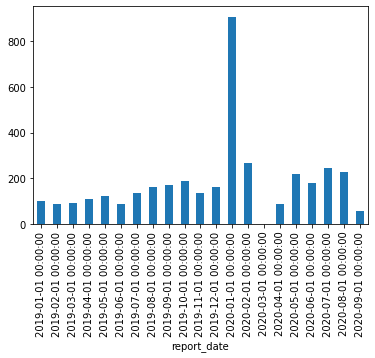

In [ ]:
# Наблюдаем странное распределение таргета по месяцам
df.groupby('report_date')['target'].sum().plot.bar();

In [ ]:
# Так как таргет сильно не сбалансирован, случайном отберем id, которые оставим
# Оставим единиц в количестве не более медианного значения
ids = df[(df['report_date'] == '2020-01-01') & (df['target'] == 1)]['client_id']
median_target = int(df.groupby('report_date')['target'].sum().median())
ids_to_keep = np.random.choice(ids, median_target)

In [ ]:
# Удаляем не выбранные единицы
df.drop(df[(df['report_date'] == '2020-01-01') & (df['target'] == 1) & (~df['client_id'].isin(ids_to_keep))].index, axis=0, inplace=True)

In [ ]:
# Удалим пустой бин
df = df.loc[df['report_date'] != '2020-03-01']

In [ ]:
# Есть значения по всем месяцам
df['current_month'] = df['report_date'].apply(lambda x: x.month) # Создаем категориальный признак
df['current_month'].value_counts(dropna=False)

9     16132
8     15879
7     15710
6     15546
5     15011
4     14886
2     14478
1     12982
12     7261
11     7144
10     6997
3      6489
Name: current_month, dtype: int64

In [ ]:
# Отсутствие информации по кредитной катре воспринимаем как 0
df['actual_credit_card_flg'].fillna(0, inplace=True)

In [ ]:
# Доля пропусков по полу
df['gender'].isna().sum() / len(df)

0.3276975389691277

In [ ]:
# Пробуем искать пол в истории клиента
# Заполним средний гендер клиента
gender_df = df[['client_id', 'gender']].groupby('client_id', as_index=False).agg('mean')
gender_df['new_gender'] = gender_df['gender'].round(0)

In [ ]:
#Часть пропусков удалось убрать
df = df.merge(gender_df, how='left', on='client_id')
df['new_gender'].isna().sum() / len(df)

0.2602094064572602

In [ ]:
# Убираем лишнее
df['gender'] = df['new_gender']
df.drop([col for col in df.columns if ('gender' in col) & (col != 'gender')], axis=1, inplace=True)

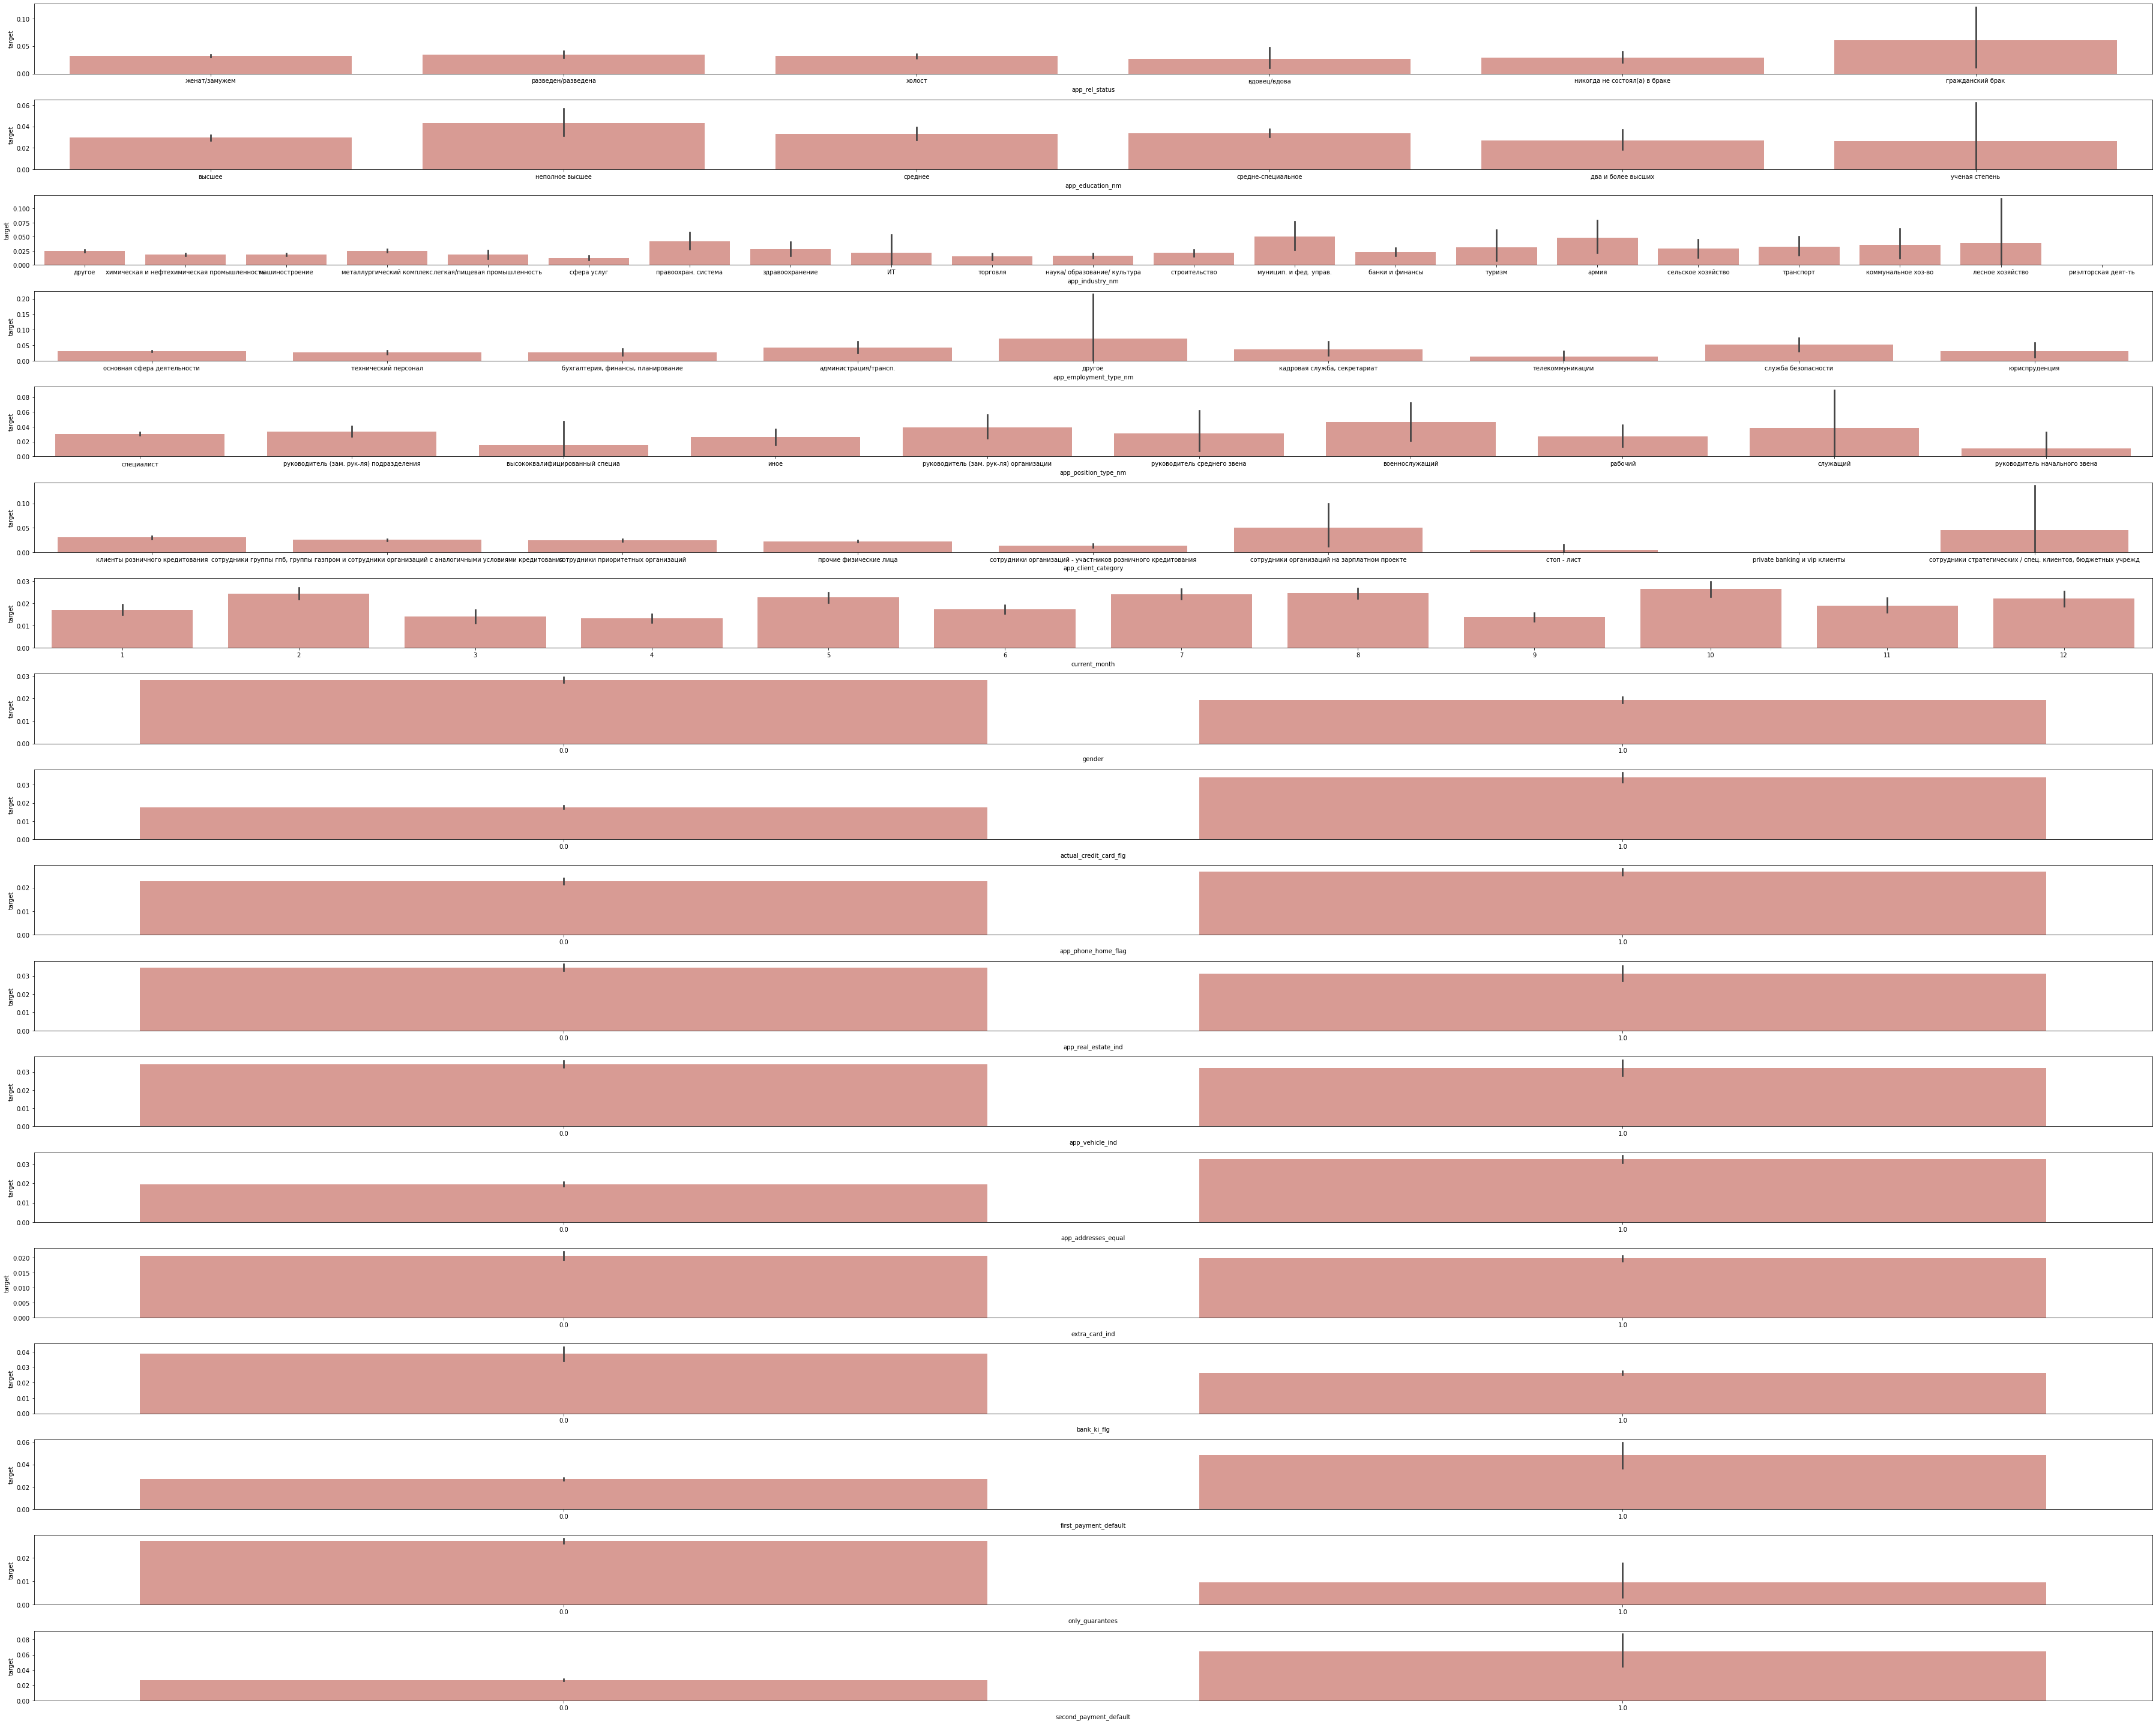

In [ ]:
# Распределение target по категориям для категориальных фичей
fig, axs = plt.subplots(18, figsize=(50, 40))
for i, plot in enumerate(categorial_df.columns.tolist() + \
            ['current_month', 'gender', 'actual_credit_card_flg', 'app_phone_home_flag', 'app_real_estate_ind', 'app_vehicle_ind',
             'app_addresses_equal', 'extra_card_ind', 'bank_ki_flg', 'first_payment_default', 'only_guarantees', 'second_payment_default']):
  sns.barplot(x=plot, y='target', data=df[categorial_df.columns.tolist() + \
            ['current_month', 'gender', 'actual_credit_card_flg', 'app_phone_home_flag', 'app_real_estate_ind', 'app_vehicle_ind',
             'app_addresses_equal', 'extra_card_ind', 'bank_ki_flg', 'first_payment_default', 'only_guarantees', 'second_payment_default', 'target']], color="salmon", saturation=.5, ax=axs[i])
  plt.tight_layout()

## Filling missing values

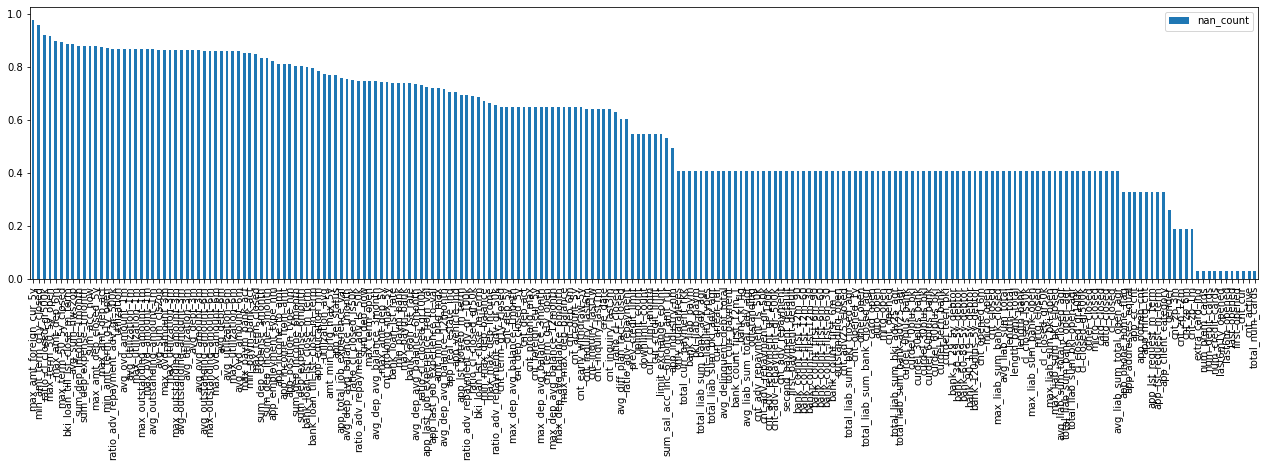

In [ ]:
# Очень много пропусков
nan_count_df = pd.DataFrame(df.isna().sum()[df.isna().sum()>0]/len(df), columns=['nan_count']).sort_values('nan_count', ascending=False)
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(111)
nan_count_df.plot.bar(ax=ax);

### Filling first order features
Порядок заполнения определется природой данных, так, например, если у клиента не было кредитов в истории, то и задолженность на текущий момент у него должна отсутсвовать, то есть быть равной 0. Заполнение некторых признаков 0, позволяет заполнить следующие признаки 0 и так далее - именно это определеят "порядок"

In [ ]:
# Данные фичи просто заполняются 0
order_1 = ['cnt_dep_5y',
'cnt_account_5y',
'app_phone_home_flag',
'cnt_zp_6m',
'cnt_zp_12m',
'cnt_zp_1m',
'cnt_zp_3m',
'total_num_cards',
'cnt_active',
'cnt_cur',
'first_opened',
'last_opened',
'last6m1y_opened',
'num_credit_cards',
'num_debit_cards',
'num_prem_cards',
'extra_card_ind',
'last6m_opened']

for col_to_fill in order_1:
  df[col_to_fill].fillna(0, inplace=True)

### Second order

In [ ]:
# 0 если 0 на текущий момент
order_2 = {'features':[
  'ratio_cl_closed_gr500k',
  'sum_acc_now',
  'bki_loan_till_lst_close_m_term',
  'utilization',
  'max_utilization_1m',
  'avg_utilization_1m',
  'avg_debt_3m',
  'max_outstanding_amount_3m',
  'max_ovd_amount_3m',
  'avg_utilization_3m',
  'max_utilization_3m',
  'avg_outstanding_amount_3m',
  'avg_ovd_amount_3m',
  'avg_outstanding_amount_6m',
  'max_utilization_6m',
  'max_outstanding_amount_6m',
  'avg_utilization_6m',
  'avg_ovd_amount_6m',
  'avg_debt_6m',
  'max_ovd_amount_6m',
  'max_paym_bank_act',
  'min_paym_bank_act',
  'amt_min_prlg_max_5y',
  'cnt_prolong_max_5y',
  'max_amt_dep_5y',
  'bank_loan_lst_close_m_term',
  'bank_loan_till_lst_close_m_term',
  'utilization_avg',
  'ratio_cl_closed_ls50k',
  'max_max_dep_income',
  'cnt_foreign_cur_5y',
  'cnt_early_withdraw_5y',
  'cnt_term_g1y_closed',
  'cnt_term_g1y_open',
  'cnt_dep_closed_5y',
  'cnt_dep_act',
  'cnt_dep_6m',
  'cnt_prolong_max',
  'ratio_cl_closed_gr100k',
  'ratio_cl_closed_gr50k',
  'bki_loan_lst_close_m_term',
  'ratio_cl_closed',
  'sum_sal_acc_inc_6month_amt_rur',
  'avg_diff_plan_fact_closed',
  'ratio_adv_repayment',
  'cur_cr_lim_month',
  'cur_credit_limit',
  'limit_exchange_count',
  'uplimit_count',
  'downlimit_count',
  'prev_credit_limit'
],
 'flags':
 [
  'cl_closed',
  'cnt_account_5y',
  'cnt_opened',
  'actual_credit_card_flg',
  'actual_credit_card_flg',
  'actual_credit_card_flg',
  'cnt_opened',
  'cnt_opened',
  'cnt_opened',
  'actual_credit_card_flg',
  'actual_credit_card_flg',
  'cnt_opened',
  'cnt_opened',
  'cnt_opened', 
  'actual_credit_card_flg',
  'cnt_opened',
  'actual_credit_card_flg',
  'cnt_opened',
  'cnt_opened', 
  'cnt_opened',
  'cnt_opened',
  'cnt_opened',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_closed',
  'cnt_opened',
  'actual_credit_card_flg',
  'cl_closed',
  'cnt_dep_5y & cnt_account_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cnt_dep_5y',
  'cl_closed',
  'cl_closed',
  'cnt_closed',
  'cl_closed',
  'cnt_zp_6m',
  'cnt_closed',
  'cnt_closed',
  'num_credit_cards',
  'num_credit_cards',
  'num_credit_cards',
  'num_credit_cards',
  'num_credit_cards',
  'num_credit_cards'
 ]}
for feature, flag in zip(order_2['features'], order_2['flags']):
  if flag.find('&') == -1:
    df.loc[df[feature][df[flag]==0].index, feature] = 0
  else:
    flag1 = flag.split(' & ')[0]
    flag2 = flag.split(' & ')[1]
    df.loc[df[feature][(df[flag1]==0) & (df[flag2]==0)].index, feature] = 0


In [ ]:
# 0 если оба 0 на текущий момент
order_2 = {'features':[
  'avg_outstanding_amount_1m',
  'avg_ovd_amount_1m',
  'max_outstanding_amount_1m',
  'max_ovd_amount_1m',
  'min_max_dep_balance',
  'bank_loan_lst_rate',
  'bank_loan_fst_rate',
  'max_paym_bank',
  'min_paym_bank',
  'max_dep_avg_balance_12month',
  'max_dep_avg_balance_6month',
  'max_dep_avg_balance_3month',
  'max_max_dep_balance',
  'app_lst_potreb_m_term',
  'app_lst_request_m_term',
  'app_fst_request_m_term'
],
 'flags':
 [
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_dep_5y & cnt_account_5y',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed',
  'cnt_dep_5y & cnt_account_5y',
  'cnt_dep_5y & cnt_account_5y',
  'cnt_dep_5y & cnt_account_5y',
  'cnt_dep_5y & cnt_account_5y',
  'cl_open & cl_closed',
  'cnt_opened & cnt_closed',
  'cnt_opened & cnt_closed'
 ]}
for feature, flag in zip(order_2['features'], order_2['flags']):
  if flag.find('&') == -1:
    df.loc[df[feature][df[flag]==0].index, feature] = 0
  else:
    flag1 = flag.split(' & ')[0]
    flag2 = flag.split(' & ')[1]
    df.loc[df[feature][(df[flag1]==0) & (df[flag2]==0)].index, feature] = 0

In [ ]:
# 1 если хотя бы один больше 0
order_2 = {'features':[
  'app_real_estate_ind',
  'app_vehicle_ind'
],
 'flags':
 [
  'mrtg_open | mrtg_closed',
  'auto_open | auto_closed'
 ]}
for feature, flag in zip(order_2['features'], order_2['flags']):
  if flag.find('|') == -1:
    df.loc[df[feature][df[flag]==0].index, feature] = 1
  else:
    flag1 = flag.split(' | ')[0]
    flag2 = flag.split(' | ')[1]
    df.loc[df[feature][(df[flag1] > 0) | (df[flag2] > 0)].index, feature] = 1

### Third order

In [ ]:
# 0 если 0 на текущий момент
order_3 = {
    'features':[
    'max_amt_foreign_cur_5y',
    'min_amt_term_g1y_closed',
    'max_term_50_5y_open',
    'max_term_50_5y_closed',
    'avg_sum_nws2op',
    'max_amt_dep_6m',
    'max_amt_dep_act',
    'max_amt_dep_closed_5y',
    'sum_dep_expense_1month',
    'sum_dep_income_1month',
    'avg_sum_cls2op',
    'max_term_closed',
    'min_amt_term_g1y_open',
    'sum_dep_expense_3month',
    'sum_dep_income_3month',
    'ratio_adv_repayment_adv_gr_500k',
    'sum_dep_expense_6month',
    'sum_dep_income_6month',
    'avg_dep_avg_balance_1month',
    'avg_dep_avg_balance_3month',
    'sum_dep_now',
    'max_term_open',
    'avg_dep_avg_balance_6month',
    'avg_dep_avg_balance_12month',
    'amt_min_prlg_max',
    'ratio_adv_repayment_adv_ls_50k',
    'max_dep_avg_balance_1month',
    'ratio_adv_repayment_adv_gr_100k',
    'ratio_adv_repayment_adv_gr_50k'
    ],
    'flags':[
    'cnt_dep_closed_5y',
    'cnt_dep_act',
    'cnt_dep_closed_5y',
    'cnt_dep_act',
    'cnt_dep_6m',
    'cnt_dep_act',
    'cnt_dep_closed_5y',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_closed_5y',
    'cnt_dep_closed_5y',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_early_withdraw_5y',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_dep_act',
    'cnt_prolong_max',
    'ratio_adv_repayment',
    'cnt_dep_act',
    'ratio_adv_repayment',
    'ratio_adv_repayment'       
    ]
}
for feature, flag in zip(order_3['features'], order_3['flags']):
  if flag.find('&') == -1:
    df.loc[df[feature][df[flag]==0].index, feature] = 0
  else:
    flag1 = flag.split(' & ')[0]
    flag2 = flag.split(' & ')[1]
    df.loc[df[feature][(df[flag1]==0) & (df[flag2]==0)].index, feature] = 0

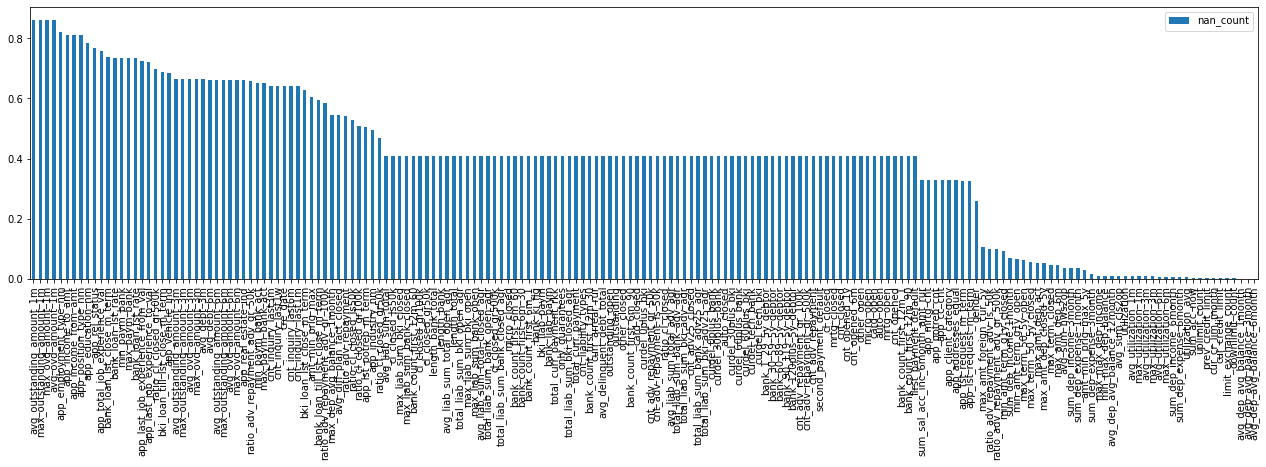

In [ ]:
# Стало лучше
nan_count_df = pd.DataFrame(df.isna().sum()[df.isna().sum()>0]/len(df), columns=['nan_count']).sort_values('nan_count', ascending=False)
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(111)
nan_count_df.plot.bar(ax=ax);

# EDA transactions

In [ ]:
# Чтобы соединятся с таблицей aggregates делаем поле report_date
transactions['report_date'] = transactions['last_day_month'] + pd.tseries.offsets.DateOffset(days=1)
transactions.head(3)

,client_id,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg,report_date
0,1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.0,30.000000,2020-01-01
1,7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.0,197.800000,2019-06-01
2,9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.0,494.939583,2020-04-01


In [ ]:
# Пропусков нет
transactions.isna().sum()

client_id         0
last_day_month    0
mcc_group         0
att_sum           0
att_cnt           0
att_sum_min       0
att_sum_max       0
att_sum_avg       0
report_date       0
dtype: int64

In [ ]:
# Уникальная комбинация полей для основного датасета
df.groupby(['client_id', 'report_date'])['cl_open'].count().max()

1

In [ ]:
# Не уникальная комбинация полей для датасета с транзакциями
transactions.groupby(['client_id', 'report_date'])['mcc_group'].count().max()

17

In [ ]:
# Смотрим какие категории транзакций есть
transactions['mcc_group'].unique()

array(['TRANSPORTATION', 'RETAIL STORES', 'NON FOOD RETAIL',
       'FINANCIAL SERVICES', 'BUSINESS SERVICES', 'MEDICAL SERVICES',
       'PUBLIC SERVICE', 'AUTO', 'unknown', 'WHOLESALE', 'ENTERTAINMENT',
       'BAR', 'SALES BY MAIL AND PHONE', 'CLOTHING STORES', 'CHARITY',
       'GOVERNMENT SERVICES', 'PERSONAL SERVICES', 'REPAIR SERVICES',
       'EDUCATION', 'HOTEL', 'VEHICLE RENTAL', 'GAMBLING',
       'CONSTRUCTION SERVICES', 'AIRLINES', 'SERVICE PROVIDER',
       'UNCLASSIFIED PAYMENTS', 'PRINTING SERVICES', 'LEGAL SERVICES'],
      dtype=object)

In [ ]:
# Заменяем unknown на UNCLASSIFIED PAYMENTS, так как по смыслу нет разницы
transactions.replace('unknown', 'UNCLASSIFIED PAYMENTS', inplace = True)

In [ ]:
# Уникальные категории транзакций
new_col = transactions['mcc_group'].unique()

In [ ]:
# Есть дубликаты
transactions.groupby(['client_id', 'report_date', 'mcc_group'])['att_sum'].count().max()

2

In [ ]:
# att_sum_avg = att_sum / att_cnt - Не будем использовать данную фичу
transactions.drop('att_sum_avg', axis=1, inplace = True)

In [ ]:
# Группировка транзакций по уникальному набору фичей 'client_id', 'report_date', 'mcc_group'
new_tr = transactions.groupby(['client_id', 'report_date', 'mcc_group'], as_index=False).agg({'att_sum': 'sum', 
                         'att_cnt':'sum', 
                         'att_sum_min':'min', 
                         'att_sum_max': 'max'})
new_tr.head(2)

,client_id,report_date,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max
0,0,2019-10-01,CLOTHING STORES,2620.0,1,2620.0,2620.0
1,0,2019-10-01,FINANCIAL SERVICES,78700.0,7,3000.0,20000.0


In [ ]:
# Притягивание транзакций в разрезе категорий в рабочий датасет
for col in new_col:
  temp_tr = new_tr[new_tr['mcc_group'] == col].copy()
  temp_tr.drop('mcc_group', axis=1, inplace = True)
  df = df.merge(temp_tr, how='left', on=['client_id', 'report_date'], suffixes=(None, '_'+col))
df.head(2)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_sum_REPAIR SERVICES,att_cnt_REPAIR SERVICES,att_sum_min_REPAIR SERVICES,att_sum_max_REPAIR SERVICES,att_sum_EDUCATION,att_cnt_EDUCATION,att_sum_min_EDUCATION,att_sum_max_EDUCATION,att_sum_HOTEL,att_cnt_HOTEL,att_sum_min_HOTEL,att_sum_max_HOTEL,att_sum_VEHICLE RENTAL,att_cnt_VEHICLE RENTAL,att_sum_min_VEHICLE RENTAL,att_sum_max_VEHICLE RENTAL,att_sum_GAMBLING,att_cnt_GAMBLING,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Заполнение 0 для отсутствующих транзакций
col_names = list(df.columns)
transactions_col = [col for col in col_names if col.startswith('att_')]
for col in transactions_col:
  df[col] = df[col].fillna(0)

In [ ]:
# Первый раз колонки не имели дубликатов и притягивались без суффикса, добавляем для них суффикс
df.rename(columns={"att_sum": "att_sum_"+new_col[0],
                   "att_cnt": "att_cnt_"+new_col[0],
                   "att_sum_min": "att_sum_min_"+new_col[0],
                   "att_sum_min": "att_sum_min_"+new_col[0]}, inplace=True)

In [ ]:
# Посчитаем суммарные транзакции клиента за месяц
avg_tr = new_tr[['client_id', 'report_date', 'att_sum']].groupby(['client_id', 'report_date'], as_index=False).agg('sum')
avg_tr.head()

,client_id,report_date,att_sum
0,0,2019-10-01,109461.00
1,0,2019-11-01,32993.48
2,0,2019-12-01,70981.85
3,0,2020-01-01,119513.90
4,0,2020-02-01,34533.62


In [ ]:
# Уникальные даты по которым есть транзакции
report_dates = avg_tr['report_date'].unique()

In [ ]:
avg_tr2 = pd.DataFrame(columns=['client_id', 'att_sum_25', 'att_sum_50', 'att_sum_75', 'count', 'report_date']) # df для хранения квартилей

# Расчет квартильных транзакций
for date in report_dates:
  temp_df = avg_tr[avg_tr['report_date']<date].groupby('client_id', as_index=False). \
  agg([lambda x: np.quantile(x, q=0.25),
       lambda x: np.quantile(x, q=0.5),
       lambda x: np.quantile(x, q=0.75),
       'count'])
  temp_df=temp_df.droplevel(0, axis=1)
  temp_df['report_date'] = date
  temp_df.rename(columns={'<lambda_0>': 'att_sum_25',
                          '<lambda_1>': 'att_sum_50',
                          '<lambda_2>': 'att_sum_75'}, inplace=True)
  temp_df.reset_index(inplace=True)
  try:
    avg_tr2 = pd.concat([avg_tr2, temp_df]) # Сохранение квартильных транзакций
  except: 
    pass

avg_tr2

,client_id,att_sum_25,att_sum_50,att_sum_75,count,report_date
0,1,7400.000,7400.00,7400.0000,1,2019-10-01
1,2,2379.230,2686.00,3403.6075,14,2019-10-01
2,4,88750.000,132500.00,155000.0000,10,2019-10-01
3,6,59.000,59.00,59.0000,1,2019-10-01
4,8,528.000,528.00,528.0000,1,2019-10-01
...,...,...,...,...,...,...
5628,9994,53710.450,58420.90,151071.5100,3,2018-10-01
5629,9995,21592.545,22778.76,47895.9200,3,2018-10-01
5630,9997,25316.390,30030.43,35632.3200,3,2018-10-01
5631,9998,59955.620,67297.25,97507.3850,3,2018-10-01


In [ ]:
# Притягиваем квартильные транзакции до текущей даты
avg_tr = avg_tr.merge(avg_tr2, how='left', on=['client_id',  'report_date'])
avg_tr.head(3)

,client_id,report_date,att_sum,att_sum_25,att_sum_50,att_sum_75,count
0,0,2019-10-01,109461.00,NaN,NaN,NaN,NaN
1,0,2019-11-01,32993.48,109461.00,109461.00,109461.00,1
2,0,2019-12-01,70981.85,52110.36,71227.24,90344.12,2


In [ ]:
# Определяем квартиль трат
avg_tr['tr_Q1'] = ((avg_tr['count'] >= 3) & (avg_tr['att_sum'] <= avg_tr['att_sum_25'])).astype(int)
avg_tr['tr_Q2'] = ((avg_tr['count'] >= 3) & (avg_tr['att_sum'] <= avg_tr['att_sum_50']) & (~avg_tr['tr_Q1'])).astype(int)
avg_tr['tr_Q3'] = ((avg_tr['count'] >= 3) & (avg_tr['att_sum'] <= avg_tr['att_sum_75']) & (avg_tr['att_sum'] > avg_tr['att_sum_50'])).astype(int)
avg_tr['tr_Q4'] = ((avg_tr['count'] >= 3) & (avg_tr['att_sum'] > avg_tr['att_sum_75'])).astype(int)
avg_tr.head(4)

,client_id,report_date,att_sum,att_sum_25,att_sum_50,att_sum_75,count,tr_Q1,tr_Q2,tr_Q3,tr_Q4
0,0,2019-10-01,109461.00,NaN,NaN,NaN,NaN,0,0,0,0
1,0,2019-11-01,32993.48,109461.000,109461.00,109461.000,1,0,0,0,0
2,0,2019-12-01,70981.85,52110.360,71227.24,90344.120,2,0,0,0,0
3,0,2020-01-01,119513.90,51987.665,70981.85,90221.425,3,0,0,0,1


In [ ]:
# Притягиваем фичи в основную таблицу
df = df.merge(avg_tr[['client_id', 'report_date', 'att_sum', 'tr_Q1', 'tr_Q2', 'tr_Q3', 'tr_Q4']],
              how='left', on=['client_id', 'report_date'])
df[['att_sum', 'tr_Q1', 'tr_Q2', 'tr_Q3', 'tr_Q4']] = df[['att_sum', 'tr_Q1', 'tr_Q2', 'tr_Q3', 'tr_Q4']].fillna(0)
df.head(1)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_cnt_EDUCATION,att_sum_min_EDUCATION,att_sum_max_EDUCATION,att_sum_HOTEL,att_cnt_HOTEL,att_sum_min_HOTEL,att_sum_max_HOTEL,att_sum_VEHICLE RENTAL,att_cnt_VEHICLE RENTAL,att_sum_min_VEHICLE RENTAL,att_sum_max_VEHICLE RENTAL,att_sum_GAMBLING,att_cnt_GAMBLING,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# More feature engineering

In [ ]:
# Посмотрим суммарные траты в предыдущие 6 месяцев
for i in range(1,7):
  avg_tr['report_date_minus_'+str(i)] = avg_tr['report_date'] - pd.tseries.offsets.DateOffset(months=i)
  avg_tr = avg_tr.merge(avg_tr[['client_id', 'report_date', 'att_sum']],
                        how='left', left_on=['client_id', 'report_date_minus_'+str(i)],
                        right_on=['client_id', 'report_date'],
                        suffixes=(None, '_minus_'+str(i)))
  avg_tr['att_sum_minus_'+str(i)] = avg_tr['att_sum_minus_'+str(i)].fillna(0)

avg_tr.head(2)

,client_id,report_date,att_sum,att_sum_25,att_sum_50,att_sum_75,count,tr_Q1,tr_Q2,tr_Q3,tr_Q4,report_date_minus_1,report_date_minus_1,att_sum_minus_1,report_date_minus_2,report_date_minus_2,att_sum_minus_2,report_date_minus_3,report_date_minus_3,att_sum_minus_3,report_date_minus_4,report_date_minus_4,att_sum_minus_4,report_date_minus_5,report_date_minus_5,att_sum_minus_5,report_date_minus_6,report_date_minus_6,att_sum_minus_6
0,0,2019-10-01,109461.00,NaN,NaN,NaN,NaN,0,0,0,0,2019-09-01,NaT,0.0,2019-08-01,NaT,0.0,2019-07-01,NaT,0.0,2019-06-01,NaT,0.0,2019-05-01,NaT,0.0,2019-04-01,NaT,0.0
1,0,2019-11-01,32993.48,109461.0,109461.0,109461.0,1,0,0,0,0,2019-10-01,2019-10-01,109461.0,2019-09-01,NaT,0.0,2019-08-01,NaT,0.0,2019-07-01,NaT,0.0,2019-06-01,NaT,0.0,2019-05-01,NaT,0.0


In [ ]:
#Объявляем модели для вычисления регрессионных коэфициентов
mms = MinMaxScaler()
temp_model = LinearRegression()

In [ ]:
#Функция построения тренда фичи по 6 месяцам
def get_trend_custom(row, feature1, feature2=None):
  y = np.array([row[feature1 + '_minus_6'], row[feature1 + '_minus_5'],
                row[feature1 +'_minus_4'], row[feature1 + '_minus_3'],
                row[feature1 +'_minus_2'], row[feature1 +'_minus_1']]).reshape(-1, 1)
  if feature2 == None:
    y = mms.fit_transform(y)
    x = np.arange(1,7).reshape(-1, 1)
  else:
    x = np.array([row[feature2 + '_minus_6'], row[feature2 +'_minus_5'],
                row[feature2 + '_minus_4'], row[feature2 + '_minus_3'],
                row[feature2 + '_minus_2'], row[feature2 +'_minus_1']]).reshape(-1, 1)
  temp_model.fit(x, y)
  return temp_model.coef_[0][0]

In [ ]:
# Построим тренд трат клиента
avg_tr['K'] = avg_tr.apply(get_trend_custom, feature1='att_sum',  axis=1)
avg_tr.head(3)

,client_id,report_date,att_sum,att_sum_25,att_sum_50,att_sum_75,count,tr_Q1,tr_Q2,tr_Q3,tr_Q4,report_date_minus_1,report_date_minus_1,att_sum_minus_1,report_date_minus_2,report_date_minus_2,att_sum_minus_2,report_date_minus_3,report_date_minus_3,att_sum_minus_3,report_date_minus_4,report_date_minus_4,att_sum_minus_4,report_date_minus_5,report_date_minus_5,att_sum_minus_5,report_date_minus_6,report_date_minus_6,att_sum_minus_6,K
0,0,2019-10-01,109461.00,NaN,NaN,NaN,NaN,0,0,0,0,2019-09-01,NaT,0.00,2019-08-01,NaT,0.0,2019-07-01,NaT,0.0,2019-06-01,NaT,0.0,2019-05-01,NaT,0.0,2019-04-01,NaT,0.0,0.000000
1,0,2019-11-01,32993.48,109461.00,109461.00,109461.00,1,0,0,0,0,2019-10-01,2019-10-01,109461.00,2019-09-01,NaT,0.0,2019-08-01,NaT,0.0,2019-07-01,NaT,0.0,2019-06-01,NaT,0.0,2019-05-01,NaT,0.0,0.142857
2,0,2019-12-01,70981.85,52110.36,71227.24,90344.12,2,0,0,0,0,2019-11-01,2019-11-01,32993.48,2019-10-01,2019-10-01,109461.0,2019-09-01,NaT,0.0,2019-08-01,NaT,0.0,2019-07-01,NaT,0.0,2019-06-01,NaT,0.0,0.128774


In [ ]:
#Суммарные траты за последние 6 месяцев
avg_tr['att_sum_6m'] = avg_tr['att_sum'] + avg_tr['att_sum_minus_1'] + avg_tr['att_sum_minus_2'] + \
avg_tr['att_sum_minus_3'] + avg_tr['att_sum_minus_4'] + avg_tr['att_sum_minus_5']

In [ ]:
#Притягиваем фичи в основную таблицу
df = df.merge(avg_tr[['client_id', 'report_date', 'K', 'att_sum_6m',
                      'att_sum_minus_1', 'att_sum_minus_2', 'att_sum_minus_3',
                      'att_sum_minus_4', 'att_sum_minus_5', 'att_sum_minus_6']],
              how='left', on=['client_id', 'report_date'])

df[['att_sum_minus_1', 'att_sum_minus_2', 'att_sum_minus_3', 'att_sum_minus_4', 'att_sum_minus_5', 'att_sum_minus_6']] = \
df[['att_sum_minus_1', 'att_sum_minus_2', 'att_sum_minus_3', 'att_sum_minus_4', 'att_sum_minus_5', 'att_sum_minus_6']].fillna(0)

df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_cnt_VEHICLE RENTAL,att_sum_min_VEHICLE RENTAL,att_sum_max_VEHICLE RENTAL,att_sum_GAMBLING,att_cnt_GAMBLING,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,att_sum_minus_1,att_sum_minus_2,att_sum_minus_3,att_sum_minus_4,att_sum_minus_5,att_sum_minus_6
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,56170.11,800640.5,35131.81,747838.77,337646.32,0.0


In [ ]:
# Фичи по которым хотим посмотреть историю
trend_features = ['sum_dep_now', 'sum_acc_now', 'max_utilization_1m']

# Строим тренды по перечисленным фичам
for feature in trend_features:
  for i in range(1,7):
    df['report_date_minus_'+str(i)] = df['report_date'] - pd.tseries.offsets.DateOffset(months=i)
    df = df.merge(df[['client_id', 'report_date', feature]],
                      how='left', left_on=['client_id', 'report_date_minus_'+str(i)],
                      right_on=['client_id', 'report_date'],
                      suffixes=(None, '_minus_'+str(i)))
    df[feature+'_minus_'+str(i)] = df[feature+'_minus_'+str(i)].fillna(0)
    df.drop(['report_date_minus_'+str(i)], axis=1, inplace=True)
  
  df[feature + '_K'] = df.apply(get_trend_custom, feature1=feature, axis=1)

df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,att_sum_minus_1,att_sum_minus_2,att_sum_minus_3,att_sum_minus_4,att_sum_minus_5,att_sum_minus_6,sum_dep_now_minus_1,sum_dep_now_minus_2,sum_dep_now_minus_3,sum_dep_now_minus_4,sum_dep_now_minus_5,sum_dep_now_minus_6,sum_dep_now_K,sum_acc_now_minus_1,sum_acc_now_minus_2,sum_acc_now_minus_3,sum_acc_now_minus_4,sum_acc_now_minus_5,sum_acc_now_minus_6,sum_acc_now_K,max_utilization_1m_minus_1,max_utilization_1m_minus_2,max_utilization_1m_minus_3,max_utilization_1m_minus_4,max_utilization_1m_minus_5,max_utilization_1m_minus_6,max_utilization_1m_K
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,6.569723e+07,6.534019e+07,6.493116e+07,6.459154e+07,6.361533e+07,6.181781e+07,0.183468,27.149094,27.925674,26.635224,26.491752,27.461028,27.145188,0.031023,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,56170.11,800640.5,35131.81,747838.77,337646.32,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['acc_now_att_sum_K'] = df.apply(get_trend_custom, feature1='att_sum', feature2='sum_acc_now', axis=1)
df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,att_sum_minus_1,att_sum_minus_2,att_sum_minus_3,att_sum_minus_4,att_sum_minus_5,att_sum_minus_6,sum_dep_now_minus_1,sum_dep_now_minus_2,sum_dep_now_minus_3,sum_dep_now_minus_4,sum_dep_now_minus_5,sum_dep_now_minus_6,sum_dep_now_K,sum_acc_now_minus_1,sum_acc_now_minus_2,sum_acc_now_minus_3,sum_acc_now_minus_4,sum_acc_now_minus_5,sum_acc_now_minus_6,sum_acc_now_K,max_utilization_1m_minus_1,max_utilization_1m_minus_2,max_utilization_1m_minus_3,max_utilization_1m_minus_4,max_utilization_1m_minus_5,max_utilization_1m_minus_6,max_utilization_1m_K,acc_now_att_sum_K
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,6.569723e+07,6.534019e+07,6.493116e+07,6.459154e+07,6.361533e+07,6.181781e+07,0.183468,27.149094,27.925674,26.635224,26.491752,27.461028,27.145188,0.031023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,56170.11,800640.5,35131.81,747838.77,337646.32,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Таргет предыдущего месяца
df['report_date_minus_1'] = df['report_date'] - pd.tseries.offsets.DateOffset(months=1)

df = df.merge(df[['client_id', 'report_date', 'target']],
              how='left', left_on=['client_id', 'report_date_minus_1'],
              right_on=['client_id', 'report_date'],
              suffixes=(None, '_prev'))

df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,att_sum_minus_1,att_sum_minus_2,att_sum_minus_3,att_sum_minus_4,att_sum_minus_5,att_sum_minus_6,sum_dep_now_minus_1,sum_dep_now_minus_2,sum_dep_now_minus_3,sum_dep_now_minus_4,sum_dep_now_minus_5,sum_dep_now_minus_6,sum_dep_now_K,sum_acc_now_minus_1,sum_acc_now_minus_2,sum_acc_now_minus_3,sum_acc_now_minus_4,sum_acc_now_minus_5,sum_acc_now_minus_6,sum_acc_now_K,max_utilization_1m_minus_1,max_utilization_1m_minus_2,max_utilization_1m_minus_3,max_utilization_1m_minus_4,max_utilization_1m_minus_5,max_utilization_1m_minus_6,max_utilization_1m_K,acc_now_att_sum_K,report_date_minus_1,report_date_prev,target_prev
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,6.569723e+07,6.534019e+07,6.493116e+07,6.459154e+07,6.361533e+07,6.181781e+07,0.183468,27.149094,27.925674,26.635224,26.491752,27.461028,27.145188,0.031023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2019-10-01,2019-10-01,False
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-01,2019-10-01,False
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,56170.11,800640.5,35131.81,747838.77,337646.32,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-01,2019-10-01,False


In [ ]:
# Флаг снижения кредитной нагрузки
df = df.merge(df[['client_id', 'report_date', 'total_curr_payment']],
              how='left', left_on=['client_id', 'report_date_minus_1'],
              right_on=['client_id', 'report_date'],
              suffixes=(None, '_minus_1'))

df['total_curr_payment_flag'] = (df['total_curr_payment']<df['total_curr_payment_minus_1']).astype(int)
df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,att_sum_minus_1,att_sum_minus_2,att_sum_minus_3,att_sum_minus_4,att_sum_minus_5,att_sum_minus_6,sum_dep_now_minus_1,sum_dep_now_minus_2,sum_dep_now_minus_3,sum_dep_now_minus_4,sum_dep_now_minus_5,sum_dep_now_minus_6,sum_dep_now_K,sum_acc_now_minus_1,sum_acc_now_minus_2,sum_acc_now_minus_3,sum_acc_now_minus_4,sum_acc_now_minus_5,sum_acc_now_minus_6,sum_acc_now_K,max_utilization_1m_minus_1,max_utilization_1m_minus_2,max_utilization_1m_minus_3,max_utilization_1m_minus_4,max_utilization_1m_minus_5,max_utilization_1m_minus_6,max_utilization_1m_K,acc_now_att_sum_K,report_date_minus_1,report_date_prev,target_prev,report_date_minus_1,total_curr_payment_minus_1,total_curr_payment_flag
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,6.569723e+07,6.534019e+07,6.493116e+07,6.459154e+07,6.361533e+07,6.181781e+07,0.183468,27.149094,27.925674,26.635224,26.491752,27.461028,27.145188,0.031023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2019-10-01,2019-10-01,False,2019-10-01,NaN,0
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-01,2019-10-01,False,2019-10-01,NaN,0
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,1.0,0.0,0.0,0.0,0.034156,1991841.41,56170.11,800640.5,35131.81,747838.77,337646.32,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-01,2019-10-01,False,2019-10-01,NaN,0


In [ ]:
# Выкидываем вспомогательные столбцы
cols_to_drop = [col for col in df.columns if col.find('minus') != -1] + ['report_date_prev']
df.drop(cols_to_drop, axis=1, inplace=True)
df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_cnt_VEHICLE RENTAL,att_sum_min_VEHICLE RENTAL,att_sum_max_VEHICLE RENTAL,att_sum_GAMBLING,att_cnt_GAMBLING,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,sum_dep_now_K,sum_acc_now_K,max_utilization_1m_K,acc_now_att_sum_K,target_prev,total_curr_payment_flag
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.183468,0.031023,0.0,-0.0,False,0
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,0.0,0.0,False,0
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,0.000000,0.000000,0.0,0.0,False,0


In [ ]:
# Доля трат на финансовые сервисы
df['FINANCIAL SERVICES_share'] = df['att_sum_FINANCIAL SERVICES'] / df['att_sum']

In [ ]:
# Кредитная нагрузка
df['curr_payment_SHARE'] = df['total_curr_payment'] / df['cnt_zp_1m']

In [ ]:
# Кредитная нагрузка относительно трат
df['curr_payment_SHARE_att_sum'] = df['total_curr_payment'] / df['att_sum']

In [ ]:
report_dates = df['report_date'].unique()

In [ ]:
last_zp_df = pd.DataFrame(columns=['client_id', 'last_zp_date', 'report_date']) # df для хранения даты предыдущей зп

temp_df2 = df[['client_id', 'cnt_zp_1m', 'report_date']].copy()
# Расчет последнего месяца зарплаты
for d in  report_dates:
  temp_df = temp_df2[(temp_df2['report_date']<=d) & (temp_df2['cnt_zp_1m']>0)].groupby('client_id', as_index=False).agg('max')
  temp_df.rename(columns={'report_date': 'last_zp_date'}, inplace=True)
  temp_df['report_date'] = d
  temp_df.drop(['cnt_zp_1m'], axis=1, inplace=True)
  try:
    last_zp_df = pd.concat([last_zp_df, temp_df]) # Сохранение квартильных транзакций
  except: 
    pass

last_zp_df.head(2)

,client_id,last_zp_date,report_date
0,0,2019-11-01,2019-11-01
1,1,2019-11-01,2019-11-01


In [ ]:
# Притягиваем в рабочий df последний месяц получения зарплаты
df = df.merge(last_zp_df, how='left', on=['report_date', 'client_id'])
df['last_zp_date'] = df['last_zp_date'].fillna(report_dates.min())
df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_cnt_GAMBLING,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,sum_dep_now_K,sum_acc_now_K,max_utilization_1m_K,acc_now_att_sum_K,target_prev,total_curr_payment_flag,FINANCIAL SERVICES_share,curr_payment_SHARE,curr_payment_SHARE_att_sum,last_zp_date
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.183468,0.031023,0.0,-0.0,False,0,NaN,NaN,NaN,2019-01-01
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,0.0,0.0,False,0,NaN,NaN,NaN,2019-01-01
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,0.000000,0.000000,0.0,0.0,False,0,0.0,NaN,NaN,2019-01-01


In [ ]:
# Считаем количество месяцев с последней зарплаты
df['last_zp_month'] = df.report_date.dt.to_period('M').astype(int) - df.last_zp_date.dt.to_period('M').astype(int)
df.head(3)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,att_sum_min_GAMBLING,att_sum_max_GAMBLING,att_sum_CONSTRUCTION SERVICES,att_cnt_CONSTRUCTION SERVICES,att_sum_min_CONSTRUCTION SERVICES,att_sum_max_CONSTRUCTION SERVICES,att_sum_AIRLINES,att_cnt_AIRLINES,att_sum_min_AIRLINES,att_sum_max_AIRLINES,att_sum_SERVICE PROVIDER,att_cnt_SERVICE PROVIDER,att_sum_min_SERVICE PROVIDER,att_sum_max_SERVICE PROVIDER,att_sum_PRINTING SERVICES,att_cnt_PRINTING SERVICES,att_sum_min_PRINTING SERVICES,att_sum_max_PRINTING SERVICES,att_sum_LEGAL SERVICES,att_cnt_LEGAL SERVICES,att_sum_min_LEGAL SERVICES,att_sum_max_LEGAL SERVICES,att_sum,tr_Q1,tr_Q2,tr_Q3,tr_Q4,K,att_sum_6m,sum_dep_now_K,sum_acc_now_K,max_utilization_1m_K,acc_now_att_sum_K,target_prev,total_curr_payment_flag,FINANCIAL SERVICES_share,curr_payment_SHARE,curr_payment_SHARE_att_sum,last_zp_date,last_zp_month
0,4268,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.183468,0.031023,0.0,-0.0,False,0,NaN,NaN,NaN,2019-01-01,10
1,8951,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,0.0,0.0,False,0,NaN,NaN,NaN,2019-01-01,10
2,3485,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14413.9,1.0,0.0,0.0,0.0,0.034156,1991841.41,0.000000,0.000000,0.0,0.0,False,0,0.0,NaN,NaN,2019-01-01,10


In [ ]:
# Удалим служебную колонку
df.drop('last_zp_date', axis=1, inplace=True)

In [ ]:
# Категориальные фичи
cat_features = categorial_df.columns.tolist() + \
            ['current_month', 'gender', 'actual_credit_card_flg', 'app_phone_home_flag', 'app_real_estate_ind', 'app_vehicle_ind',
             'app_addresses_equal', 'extra_card_ind', 'only_guarantees', 'bank_ki_flg', 'first_payment_default', 'second_payment_default'] +\
             ['total_curr_payment_flag', 'tr_Q1', 'tr_Q2', 'tr_Q3', 'tr_Q4', 'last_zp_month']

# Feature selection

In [ ]:
# Заменим бесконечности на отсутствующее значение
df.replace(np.inf, np.nan, inplace=True)

In [ ]:
# Функция поиска лучшего варианта для заполнения пропусков
def find_best_strategy(df, target_feature, cat_features, features_to_drop=features_to_drop):

  strategies = ['mean', 'median', 'most_frequent', 'constant']
  strategies_cat = 'most_frequent'
  list_of_strategies = []

  for feature in df.drop(features_to_drop+[target_feature], axis=1).columns:
    if df[feature].isna().sum()==0:
      continue
    best_gini = 0
    best_strategy = None

    if feature in cat_features:
      list_of_strategies.append({'feature': feature, 'best strategy': strategies_cat, 'best gini': None})
      continue
    else:
      strategies_to_choose = strategies

    for strategy in strategies_to_choose:
      if strategy != 'constant':
        inputer = SimpleImputer(strategy=strategy)
      else:
        inputer = SimpleImputer(strategy=strategy, fill_value=0)

      data = df[[feature, 'target']]
      data[feature] = inputer.fit_transform(data[feature].values.reshape(-1, 1))

      gini = 2 * roc_auc_score(data['target'], data[feature]) - 1

      if gini < 0:
        gini *= -1
      
      if gini > best_gini:
        best_gini  = gini
        best_strategy = strategy

    list_of_strategies.append({'feature': feature, 'best strategy': best_strategy, 'best gini': gini})
    strategies_df = pd.DataFrame(list_of_strategies)
    
  return strategies_df

In [ ]:
# Функция заполнения пропусков лучшим способом
def execute_best_strategy(df, strategies_df):
  for feature, strategy in strategies_df[['feature', 'best strategy']].values:
    if strategy != 'constant':
        inputer = SimpleImputer(strategy=strategy)
    else:
        inputer = SimpleImputer(strategy=strategy, fill_value=0)
    df[feature] = inputer.fit_transform(df[feature].values.reshape(-1, 1))

  return df

In [ ]:
# Определяем лучшую стратегию заполнения пропусков
strategies_df = find_best_strategy(df, 'target', cat_features, features_to_drop=features_to_drop)

In [ ]:
# Заполняем пропуски
df = execute_best_strategy(df, strategies_df)

In [ ]:
# Функция для отбора предикторов
def feature_selection(df, cat_features, target_feature, target='cat', alpha=0.01, features_to_drop=features_to_drop):
  selected_features = {'categorical': [], 
                       'numerical': []}
  if target == 'cat':
    for feature in df.drop(features_to_drop+[target_feature], axis=1).columns:
      if feature in cat_features:
        encoder = OrdinalEncoder()
        X = encoder.fit_transform(df[feature].values.reshape(-1,1))
        _, p = chi2(X, df[target_feature].values.reshape(-1,1))
        # H0 no correlatiom
        if p < alpha:
          selected_features['categorical'].append(feature)
      else:
        # H0 no difference in means
        _, p = f_classif(df[feature].values.reshape(-1,1), df[target_feature].values.reshape(-1,1))
        if p < alpha:
          selected_features['numerical'].append(feature)
  else:
    pass

  return selected_features['categorical'], selected_features['numerical']      

In [ ]:
# Отбираем переменные
selected_cat_features, selected_num_features = feature_selection(df, cat_features, 'target')
selected_features = selected_cat_features + selected_num_features

In [ ]:
# Смотрим отобранные категориальные фичи
selected_cat_features

['actual_credit_card_flg',
 'app_rel_status',
 'app_real_estate_ind',
 'app_vehicle_ind',
 'app_education_nm',
 'app_addresses_equal',
 'app_phone_home_flag',
 'first_payment_default',
 'second_payment_default',
 'current_month',
 'tr_Q4',
 'total_curr_payment_flag',
 'last_zp_month']

In [ ]:
# Смотрим отобранные количественные фичи
np.sort(selected_num_features)

array(['FINANCIAL SERVICES_share', 'K', 'age', 'amt_min_prlg_max',
       'amt_min_prlg_max_5y', 'app_cc_cnt', 'app_fst_request_m_term',
       'app_income_from_amt', 'app_income_to_amt',
       'app_last_job_experience_from_val',
       'app_last_job_experience_to_val', 'app_lst_potreb_m_term',
       'app_lst_request_m_term', 'app_potreb_cnt',
       'app_total_job_experience_val', 'att_cnt_AUTO',
       'att_cnt_BUSINESS SERVICES', 'att_cnt_CLOTHING STORES',
       'att_cnt_ENTERTAINMENT', 'att_cnt_FINANCIAL SERVICES',
       'att_cnt_GAMBLING', 'att_cnt_GOVERNMENT SERVICES',
       'att_cnt_NON FOOD RETAIL', 'att_cnt_PERSONAL SERVICES',
       'att_cnt_PUBLIC SERVICE', 'att_cnt_REPAIR SERVICES',
       'att_cnt_RETAIL STORES', 'att_cnt_SALES BY MAIL AND PHONE',
       'att_cnt_TRANSPORTATION', 'att_cnt_WHOLESALE', 'att_sum',
       'att_sum_6m', 'att_sum_BUSINESS SERVICES',
       'att_sum_NON FOOD RETAIL', 'att_sum_RETAIL STORES',
       'att_sum_max_BUSINESS SERVICES', 'att_sum_m

In [ ]:
print('Всего отобрано фичей:', len(selected_features))

Всего отобрано фичей: 199


# ML

In [ ]:
# Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['target'].astype(int), test_size=0.2, random_state=SEED)

In [ ]:
# # Сюда будем записывать результаты работы алгоритма
# results = []

In [ ]:
# Выделим бинарные переменные
binary_features = [feature for feature in X_train[selected_cat_features].columns if len(df[feature].unique()) == 2]

In [ ]:
# Под Catboost меняем np.nan на "missing value" или преобразуем к типу int 
for col in selected_cat_features:
  try:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)
  except:
    X_train[col].fillna('missing value', inplace=True)
    X_test[col].fillna('missing value', inplace=True)

In [ ]:
cat_features_for_catboost = list(set(selected_cat_features) - set(binary_features))

In [ ]:
# Данные параметры полученны по результатам работы GridSearch
params_best = {
 'depth': 8,
 'iterations': 250,
 'l2_leaf_reg': 3,
 'learning_rate': 0.05,
 'random_strength': 0.05}

In [ ]:
# Определяем модель
model = CatBoostClassifier(eval_metric='F1', 
                           cat_features=cat_features_for_catboost,
                           auto_class_weights='Balanced', 
                           verbose=1,
                           random_seed=SEED,
                           bootstrap_type='Bernoulli',
                           one_hot_max_size=3, **params_best)

In [ ]:
# # Uncommenct for gridsearch
# # Параметры
# params = {'iterations': [300, 250],  # [200, 300] [300, 400]
#           'depth': [8], # [8, 9]
#           'learning_rate': [0.05, 0.06],
#           'l2_leaf_reg':[2.5, 3], # 3 is default [3, 4] [2, 3]
#           'random_strength':[0.05, 0.1] # 1 is default [1, 2] [1, 0.5] [0.3, 0.1]
#          }
# # Поиск лучших
# model_grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=5, verbose=2)

In [ ]:
# model_grid.fit(X_train, y_train)

In [ ]:
#  model_grid.best_params_

In [ ]:
# model = model_grid.best_estimator_
model.fit(X_train, y_train)

0:	learn: 0.7069971	total: 527ms	remaining: 2m 11s
1:	learn: 0.7159862	total: 1.01s	remaining: 2m 5s
2:	learn: 0.7153481	total: 1.49s	remaining: 2m 2s
3:	learn: 0.7135664	total: 1.9s	remaining: 1m 56s
4:	learn: 0.7163608	total: 2.28s	remaining: 1m 51s
5:	learn: 0.7171918	total: 2.71s	remaining: 1m 50s
6:	learn: 0.7231946	total: 3.3s	remaining: 1m 54s
7:	learn: 0.7219242	total: 3.86s	remaining: 1m 56s
8:	learn: 0.7296756	total: 4.38s	remaining: 1m 57s
9:	learn: 0.7289067	total: 4.86s	remaining: 1m 56s
10:	learn: 0.7328332	total: 5.25s	remaining: 1m 54s
11:	learn: 0.7323679	total: 5.72s	remaining: 1m 53s
12:	learn: 0.7330039	total: 6.1s	remaining: 1m 51s
13:	learn: 0.7356610	total: 6.54s	remaining: 1m 50s
14:	learn: 0.7357721	total: 7s	remaining: 1m 49s
15:	learn: 0.7365172	total: 7.46s	remaining: 1m 49s
16:	learn: 0.7378805	total: 7.9s	remaining: 1m 48s
17:	learn: 0.7381629	total: 8.33s	remaining: 1m 47s
18:	learn: 0.7383292	total: 8.74s	remaining: 1m 46s
19:	learn: 0.7392359	total: 9.1

In [ ]:
# На 5 фолдах среднеквадратичное отклонение для лучшей комбинации параметров 0.006
# при среднем score 9,8%
# pd.DataFrame(model_grid.cv_results_).sort_values('rank_test_score')

In [ ]:
preds_test = model.predict(X_test)
print(f'F1 test {np.round(f1_score(y_test, preds_test), 2)}')

F1 test 0.1


In [ ]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     29117
           1       0.06      0.44      0.10       586

    accuracy                           0.84     29703
   macro avg       0.52      0.65      0.51     29703
weighted avg       0.97      0.84      0.90     29703



In [ ]:
dummy_preds_test = DummyClassifier(strategy='uniform').fit(X_train, y_train).predict(X_test)
f'Dummy f1 {f1_score(y_test, dummy_preds_test)}'

'Dummy f1 0.038407011212785155'

In [ ]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(20,30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

    return fi_df

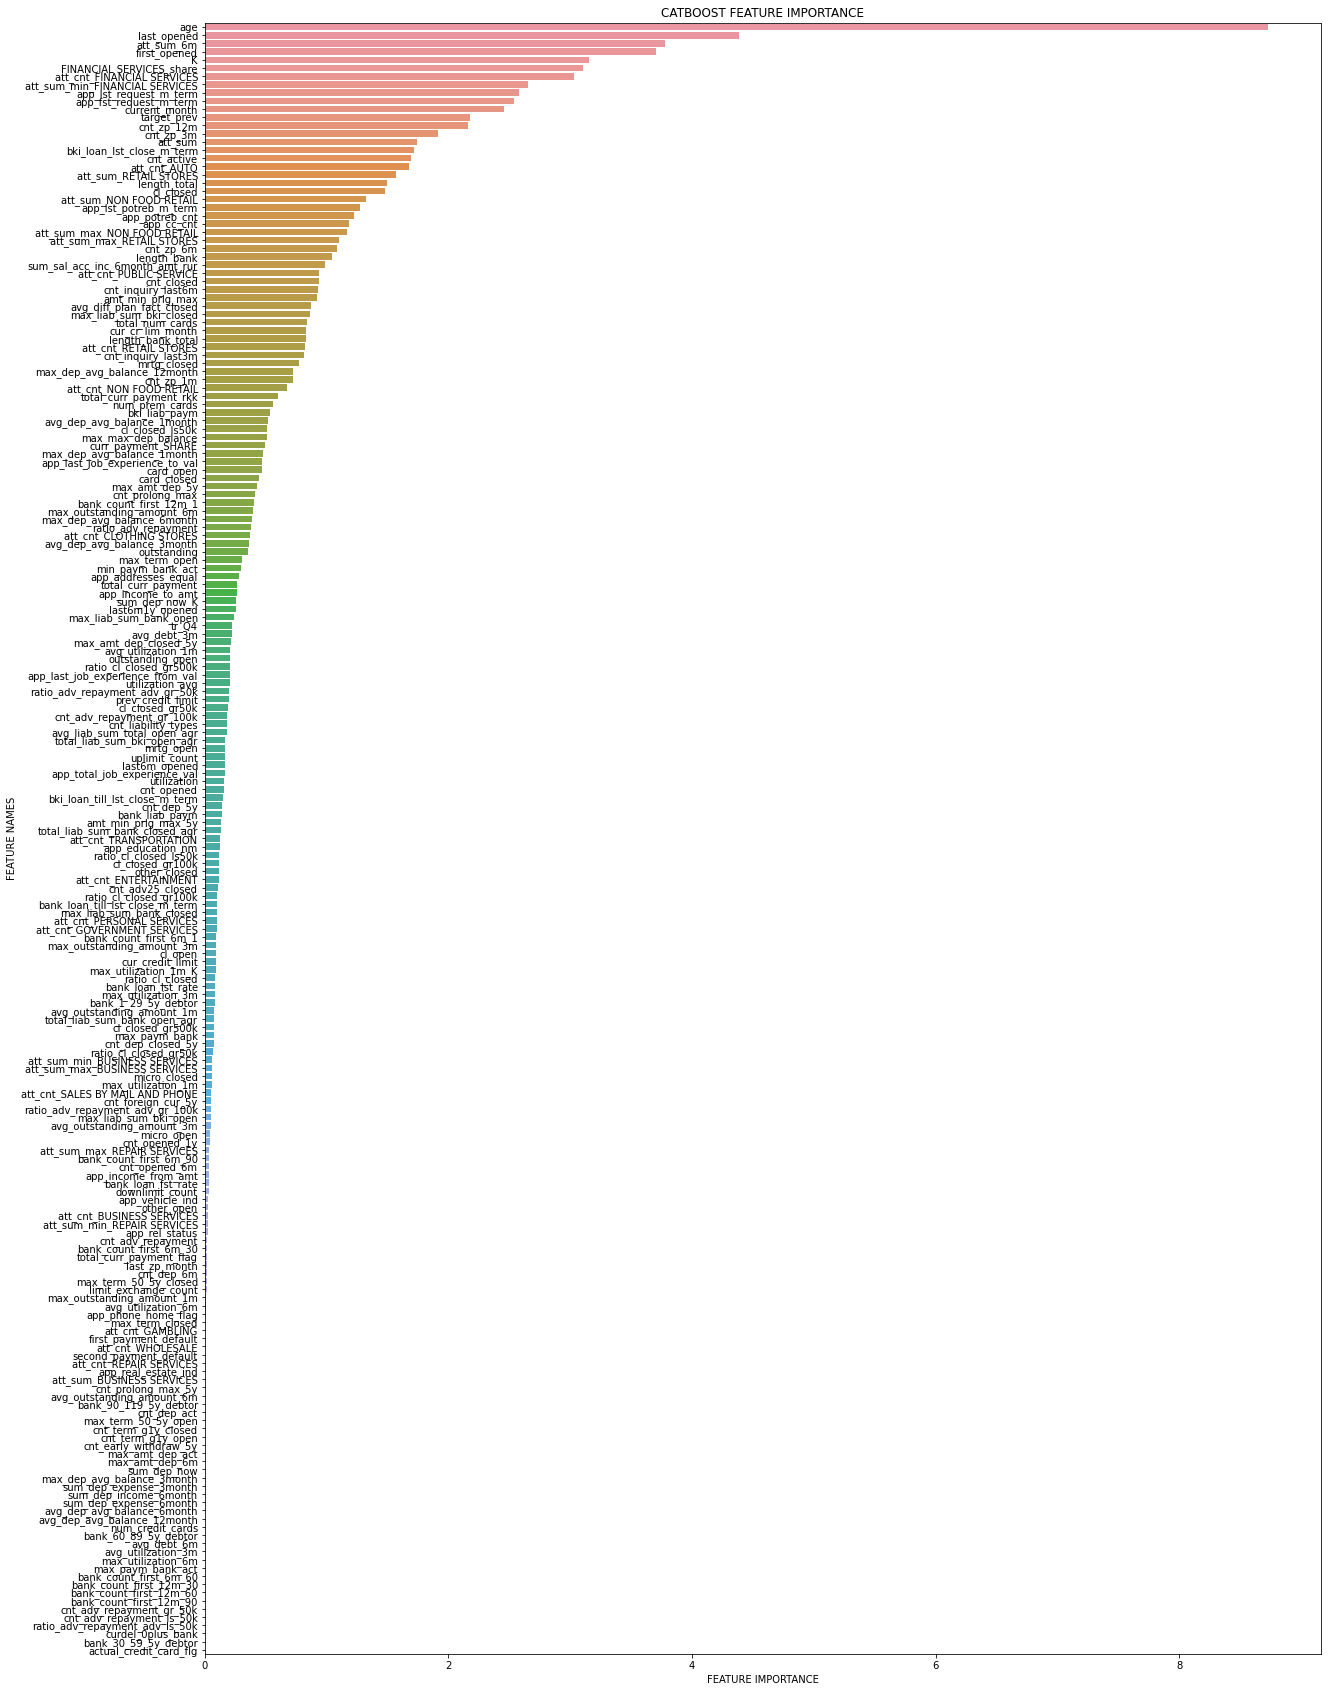

In [ ]:
fi_df = plot_feature_importance(model.get_feature_importance(), X_train.columns, 'CATBOOST')